### GROUP 45: HARSHA SUNKARA, RAGINI REDDY BANALA, RAMYA GHANTA, SHWETHA CHITLA, SREE REKHA DORASWAMY

In [567]:
#importing libraries
import math
import random
import numpy as np
from numpy.linalg import pinv, inv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import io
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.linear_model import RidgeCV, LassoCV
import numpy.matlib
import warnings
warnings.filterwarnings("ignore")

In [568]:
#loading the data
df=pd.read_csv('insurance-1.csv')

In [569]:
#dropping region as mentioned
df.drop('region',inplace=True,axis=1)

In [570]:
#one hot encoding for the column : 'sex'
#female=1
#male=0
df_one = pd.get_dummies(df["sex"])
df_two = pd.concat((df_one, df), axis=1)
df_two = df_two.drop(["sex"], axis=1)
df_two = df_two.drop(["male"], axis=1)
result = df_two.rename(columns={"female": "sex"})

In [571]:
# one hot encoding for smoker columns
#yes=1
#no=0
df_one = pd.get_dummies(result["smoker"])
df_two = pd.concat((df_one, result), axis=1)
df_two = df_two.drop(["smoker"], axis=1)
df_two = df_two.drop(["no"], axis=1)
result1 = df_two.rename(columns={"yes": "smoker"})

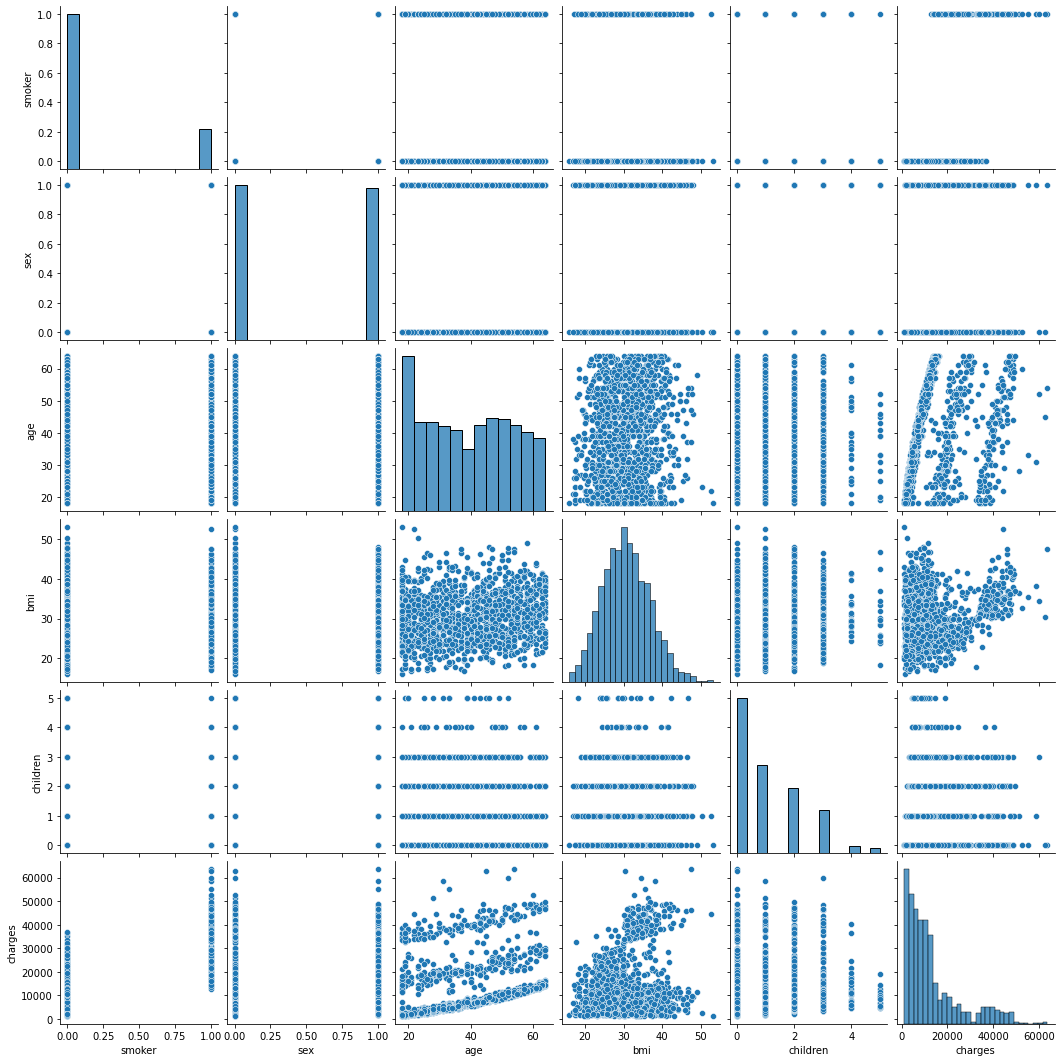

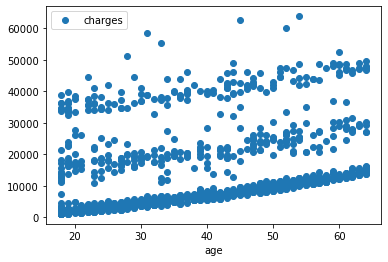

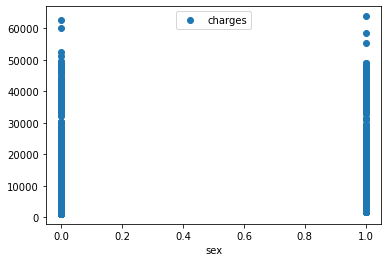

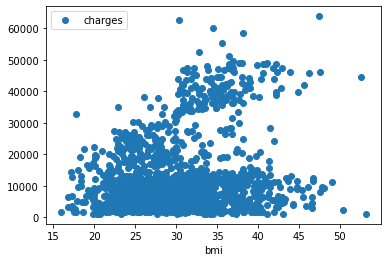

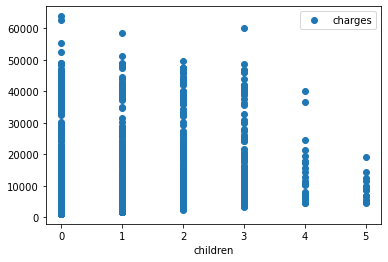

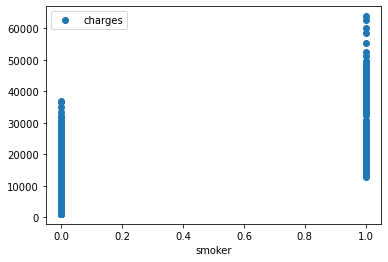

In [572]:
#Inspect / analyze the data set before starting
sns.pairplot(result1)
result1.plot('age','charges', style='o')
result1.plot('sex','charges', style='o')
result1.plot('bmi','charges', style='o')
result1.plot('children','charges', style='o')
result1.plot('smoker','charges', style='o')
plt.show()

In [573]:
# all columns except output in X
X = result1.loc[:, df.columns != 'charges']
Y = result1.loc[:,'charges':]

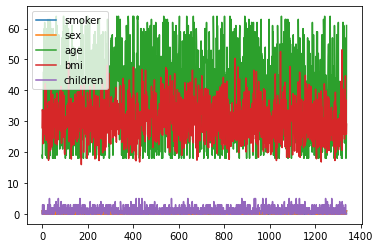

In [574]:
# plotted the data before normalizing
ax=plt.gca()
X.plot(kind='line',ax=ax)
plt.show()

In [575]:
# standardizing the data
data=X
muX=data[["smoker","sex","age","bmi","children"]].mean()
muX=np.array(muX)
stdX=data[["smoker","sex","age","bmi","children"]].std()
stdX=np.array(stdX)
repmu=np.matlib.repmat(muX,1338,1)
repstd=np.matlib.repmat(stdX,1338,1)
standardizedX = (data-repmu)/repstd

In [576]:
#mean of standardized data
standardizedX.mean()

smoker     -2.889235e-16
sex         2.124194e-17
age        -1.810543e-16
bmi         1.553275e-15
children   -2.540735e-16
dtype: float64

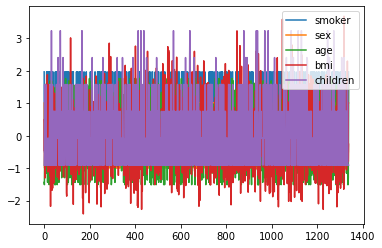

In [577]:
# plot of the data after standardizing
ax=plt.gca()
standardizedX.plot(kind='line',ax=ax)
plt.show()

In [578]:
#Splitting the dataset into train and test
XTrain, XTest, YTrain, YTest = train_test_split(standardizedX, Y, train_size=0.5)

In [579]:
# Adding bias to the train and test data sets.
XTrain.insert(0, 'bias', 1)
XTest.insert(0, 'bias', 1)

In [580]:
#fitting the model with respect to the regularization
def regularization_l1_l2(XTrain, YTrain, YHat, weights=None, regularization=None):
    t = YTrain.shape[0]
    regularize_val = 0
    if regularization == 'l1': 
        model = LassoCV()
        model.fit(XTrain, YTrain)
        alpha = model.alpha_
        regularize_val = alpha * np.sign(weights)
    elif regularization == 'l2':
        regressor = RidgeCV()
        regressor.fit(XTrain, YTrain)
        alpha=regressor.alpha_
        regularize_val = 2 * alpha * weights
    return (2/t) * XTrain.T.dot(YHat-YTrain.values) + regularize_val

In [581]:
#Defined this function to plot graphs using Gradient Descent with updated weights
def getWeights(alg_Type=None, x_Train=None, y_Train=None, x_Test=None, y_Test=None, regularization=None, batch_Size=20, epochs=100, learn_Rate=None,threshold=None):
    
    if(alg_Type=='batch'):
        batch_Size = -1
    elif(alg_Type=='stochastic'):
        batch_Size = 1
    else:
        batch_Size = 20
    
    meanSqrList = []
    #mseOld = float('inf')
    meanSqrOld = 0
    s, t = x_Train.shape
    wght = np.random.randn(t, 1)
    

    for i in range(epochs):
        if(alg_Type=='batch'):
            XTrain = x_Train
            YTrain = y_Train
        else:
            indices = np.random.randint(0, s, batch_Size)
            XTrain = x_Train.iloc[indices, :]
            YTrain = y_Train.iloc[indices, :]

        YHat = XTrain.dot(wght)
        grdnt = regularization_l1_l2(XTrain, YTrain, YHat, wght, regularization=regularization)
        mse = np.square(np.subtract(YHat,YTrain)).mean() # Mean Squared Error(MSE): train Data.
        
        if abs(float(mse[0]-meanSqrOld)) < threshold:
            cnt = cnt+1
        else:
            cnt = 0

        #Condition to stop the training by breaking the loop
        if cnt > 20:
            print(f'The error rate has not improved from the {i} iteration, so we are stopping the training by breaking the loop.')
            break
        
        meanSqrList.append(mse)
        meanSqrOld = mse
        wght -= learn_Rate * grdnt
        
    plt.plot(range(len(meanSqrList)), meanSqrList, label='Mean Squared Error')
    plt.title(f'Mean Squared Error: {alg_Type} type')
    plt.xlabel('No. of Iterations')
    plt.ylabel('MSE')
    plt.legend()
    plt.show() 
    
    YHat_Test = x_Test.dot(wght)

    plt.plot(range(x_Test.shape[0]), y_Test, '--', label='yTest: Actual values')
    plt.plot(range(x_Test.shape[0]), YHat_Test.values, label='yTest: Predicted values')
    plt.title('Test data: Actual Vs Predicted values')
    plt.ylabel('Output')
    plt.legend()
    plt.show()

    #Output plots for the train data.
    YHat = x_Test.dot(wght)
    YHat.columns = ['YH']
    pltData = pd.concat([x_Test.loc[:, 'smoker':], YHat], axis=1)
    
    if 'smoker' in pltData.columns:
        dFrame = pltData.sort_values(by=['smoker'])
        plt.plot(x_Test['smoker'], y_Test, 'o', label='yTest: Actual values')
        plt.plot(dFrame['smoker'], dFrame['YH'], label='Regression Line')
        plt.title(f'{alg_Type} Gradient Descent: smoker Vs Regression Line')
        plt.xlabel('smoker')
        plt.ylabel('Output')
        plt.legend()
        plt.show()
        
    if 'sex' in pltData.columns:
        dFrame = pltData.sort_values(by=['sex'])
        plt.plot(x_Test['sex'], y_Test, 'o', label='yTest: Actual values')
        plt.plot(dFrame['sex'], dFrame['YH'], label='Regression Line')
        plt.title(f'{alg_Type} Gradient Descent: sex Vs Regression Line')
        plt.xlabel('sex')
        plt.ylabel('Output')
        plt.legend()
        plt.show()
    if 'age' in pltData.columns:
        dFrame = pltData.sort_values(by=['age'])
        plt.plot(x_Test['age'], y_Test, 'o', label='yTest: Actual values')
        plt.plot(dFrame['age'], dFrame['YH'], label='Regression Line')
        plt.title(f'{alg_Type} Gradient Descent: age Vs Regression Line')
        plt.xlabel('age')
        plt.ylabel('Output')
        plt.legend()
        plt.show()
    if 'bmi' in pltData.columns:
        dFrame = pltData.sort_values(by=['bmi'])
        plt.plot(x_Test['bmi'], y_Test, 'o', label='yTest: Actual values')
        plt.plot(dFrame['bmi'], dFrame['YH'], label='Regression Line')
        plt.title(f'{alg_Type} Gradient Descent: bmi Vs Regression Line')
        plt.xlabel('bmi')
        plt.ylabel('Output')
        plt.legend()
        plt.show()
    if 'children' in pltData.columns:
        dFrame = pltData.sort_values(by=['children'])
        plt.plot(x_Test['children'], y_Test, 'o', label='yTest: Actual values')
        plt.plot(dFrame['children'], dFrame['YH'], label='Regression Line')
        plt.title(f'{alg_Type} Gradient Descent: children Vs Regression Line')
        plt.xlabel('children')
        plt.ylabel('Output')
        plt.legend()
        plt.show()
     
    #  Mean Squared Error(MSE): test Data.
    mse = np.square(np.subtract(YHat_Test,y_Test)).mean() 
    print(mse)
    #print(meanSqrList)
    return wght

The error rate has not improved from the 24 iteration, so we are stopping the training by breaking the loop.


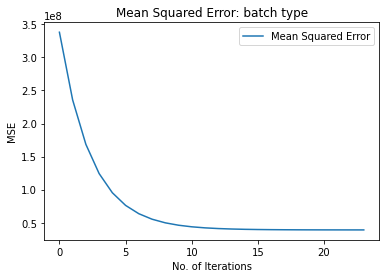

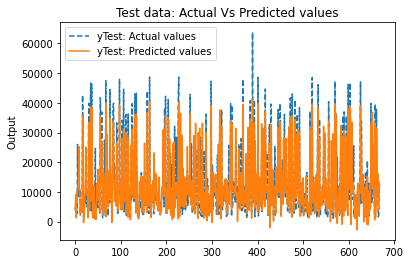

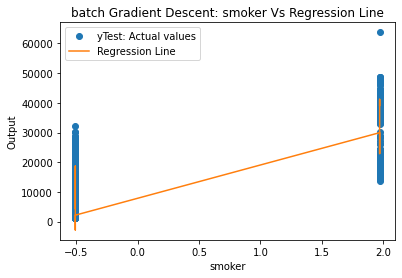

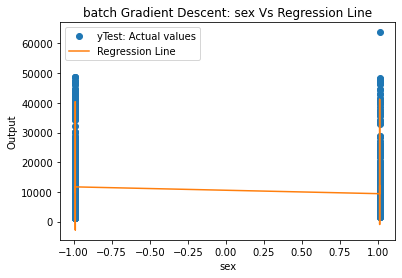

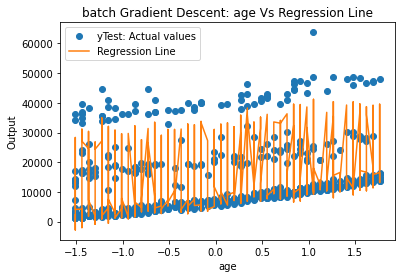

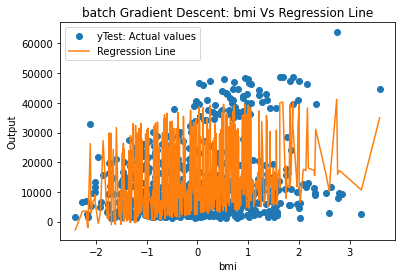

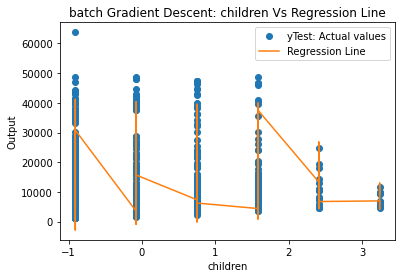

0    3.441880e+07
dtype: float64


In [582]:
#Batch Gradient Descent without regularization
weights = getWeights(alg_Type='batch',x_Train=XTrain,y_Train=YTrain,x_Test=XTest,y_Test=YTest,learn_Rate=0.09,threshold=3.580427e+07)   


The error rate has not improved from the 24 iteration, so we are stopping the training by breaking the loop.


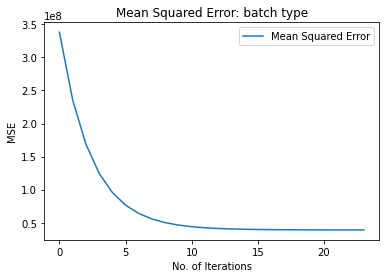

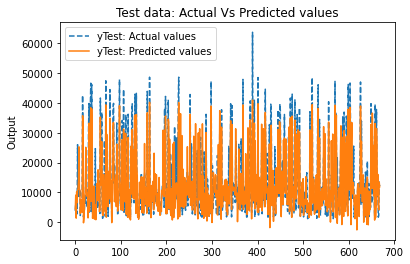

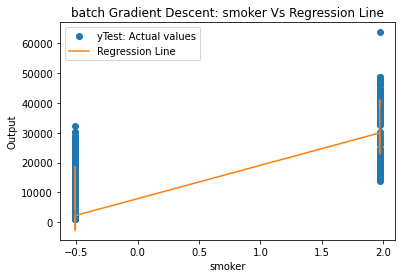

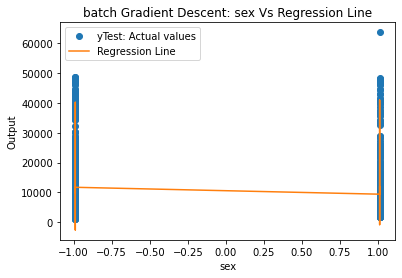

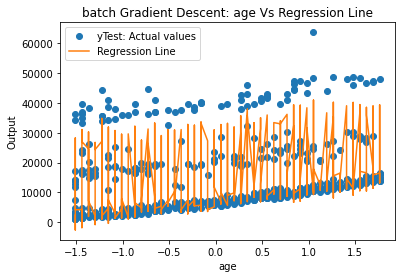

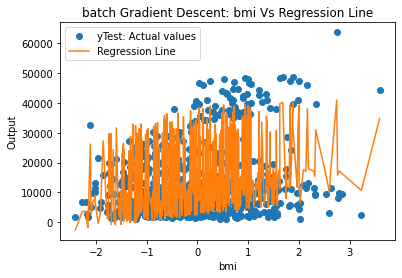

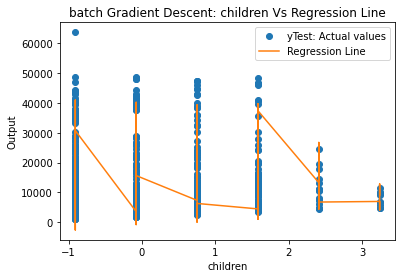

0    3.442039e+07
dtype: float64


In [583]:
#Batch Gradient Descent with L1 regularization
weights = getWeights(alg_Type='batch',x_Train=XTrain,y_Train=YTrain,x_Test=XTest,y_Test=YTest,regularization='l1',learn_Rate=0.09,threshold=3.619520e+07)

The error rate has not improved from the 24 iteration, so we are stopping the training by breaking the loop.


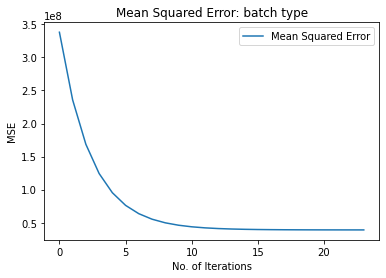

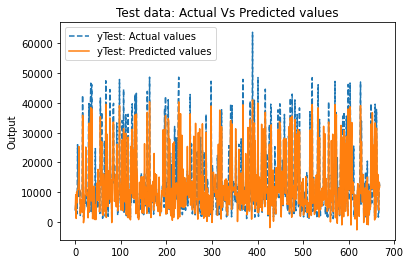

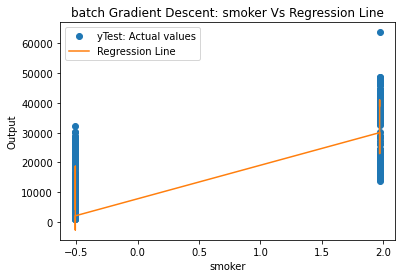

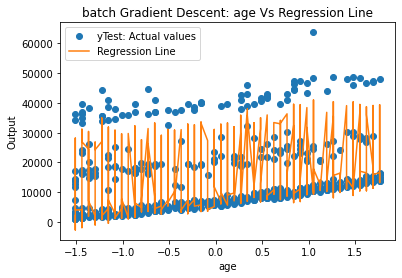

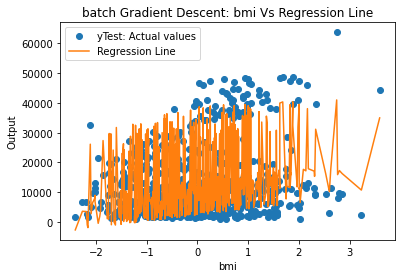

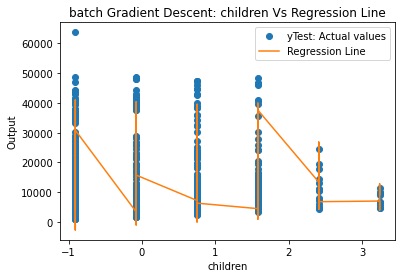

0    3.441194e+07
dtype: float64


In [584]:
#Dropping the minimum weight attribute and performing L1 regularization for batch gradient descent
l1XTrain = XTrain.drop(weights.idxmin()[0], axis=1)
l1XTest = XTest.drop(weights.idxmin()[0], axis=1)
weights = getWeights(alg_Type='batch',x_Train=l1XTrain,y_Train=YTrain,x_Test=l1XTest,y_Test=YTest,regularization='l1',learn_Rate=0.09,threshold=3.580427e+07)

#sex

The error rate has not improved from the 23 iteration, so we are stopping the training by breaking the loop.


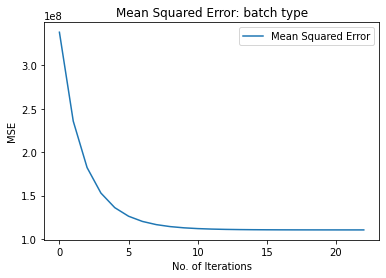

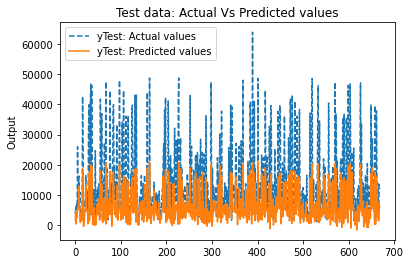

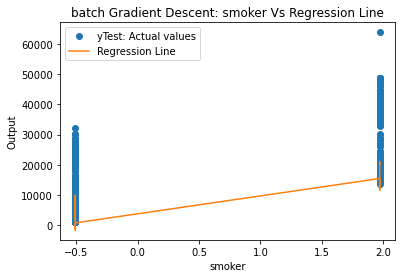

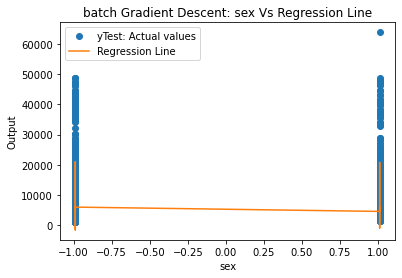

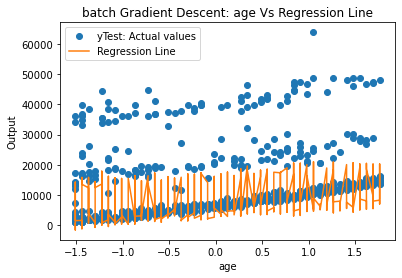

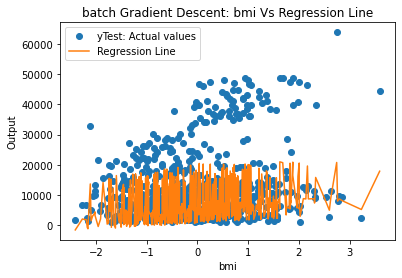

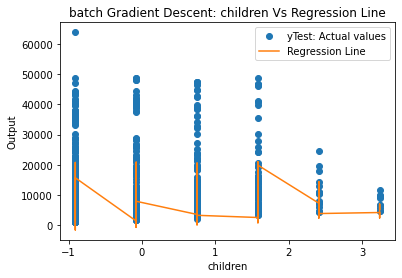

0    9.980852e+07
dtype: float64


In [585]:
#Batch Gradient Descent with L2 regularization
weights = getWeights(alg_Type='batch',x_Train=XTrain,y_Train=YTrain,x_Test=XTest,y_Test=YTest,regularization='l2',learn_Rate=0.09,threshold=3.580427e+07)

The error rate has not improved from the 23 iteration, so we are stopping the training by breaking the loop.


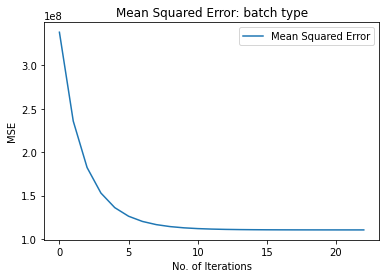

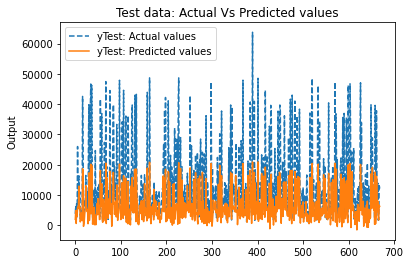

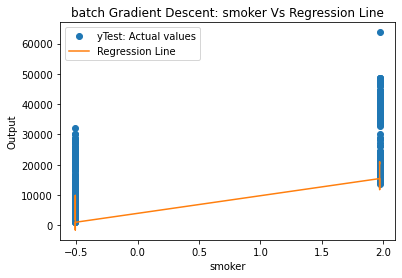

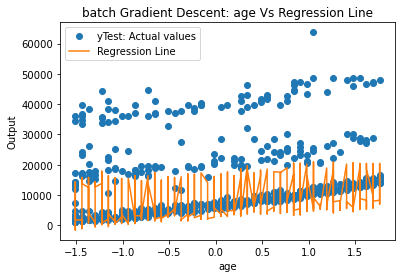

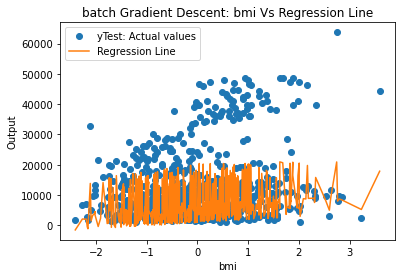

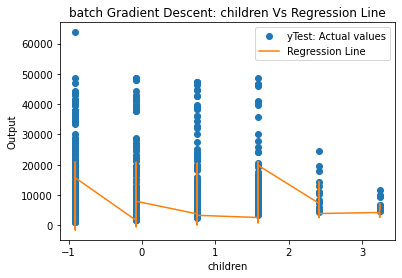

0    9.985033e+07
dtype: float64


In [586]:
#Dropping the minimum weight attribute and performing L2 regularization for batch gradient descent
l2XTrain = XTrain.drop(weights.idxmin()[0], axis=1)
l2XTest = XTest.drop(weights.idxmin()[0], axis=1)
weights = getWeights(alg_Type='batch',x_Train=l2XTrain,y_Train=YTrain,x_Test=l2XTest,y_Test=YTest,regularization='l2',learn_Rate=0.09,threshold=3.580427e+07)
#sex

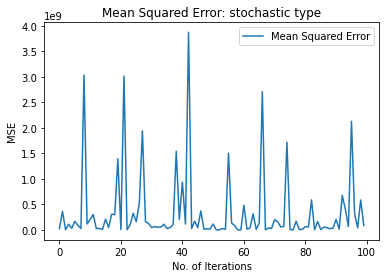

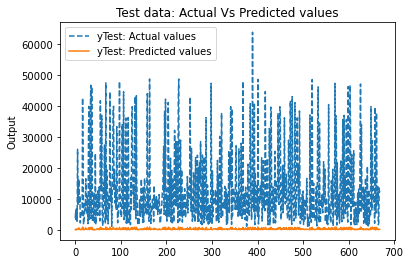

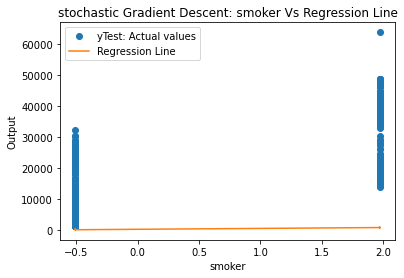

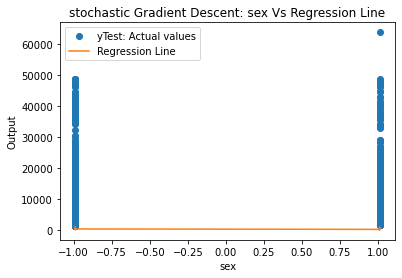

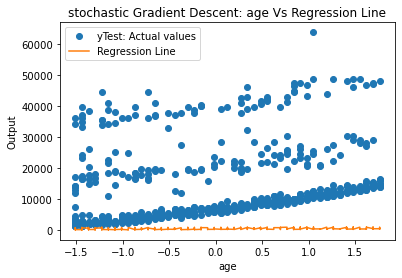

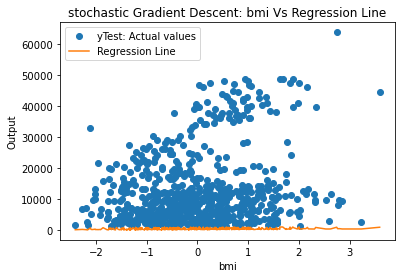

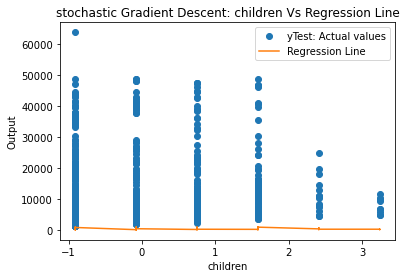

0    2.959047e+08
dtype: float64


In [587]:
#Stochastic Gradient Descent without regularization
weights = getWeights(alg_Type='stochastic',x_Train=XTrain,y_Train=YTrain,x_Test=XTest,y_Test=YTest,learn_Rate=0.0001,threshold=1.027360e+06)    

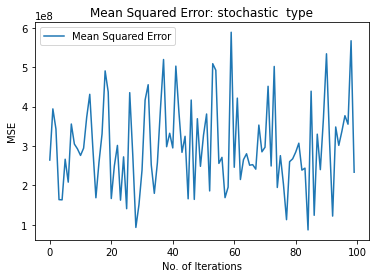

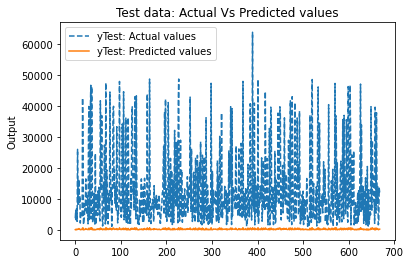

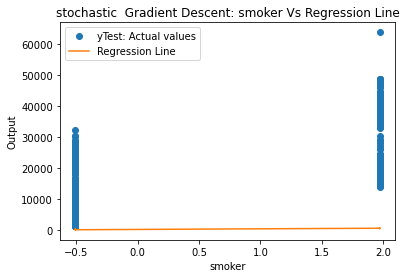

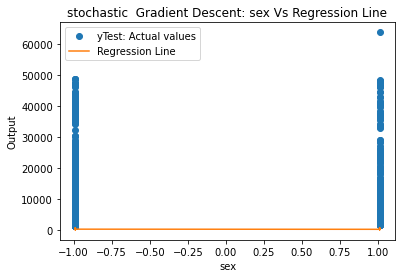

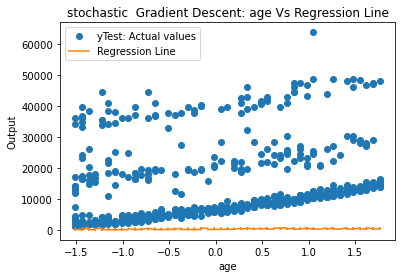

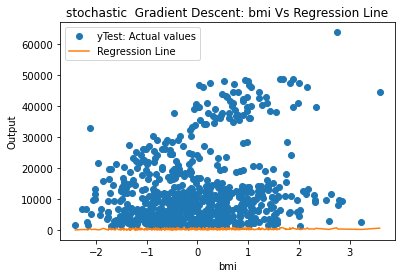

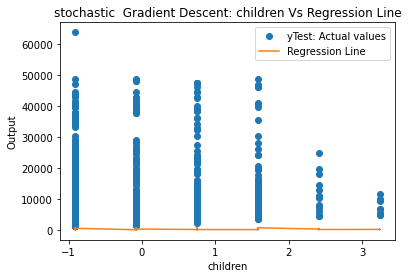

0    2.974506e+08
dtype: float64


In [588]:
#Stochastic Gradient Descent with L1 regularization
weights = getWeights(alg_Type='stochastic ',x_Train=XTrain,y_Train=YTrain,x_Test=XTest,y_Test=YTest,regularization='l1',learn_Rate=0.0001,threshold=1.027360e+06)

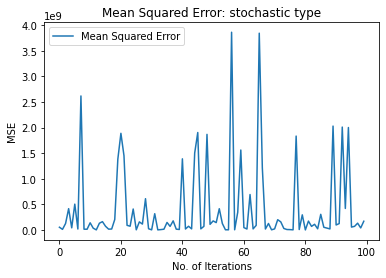

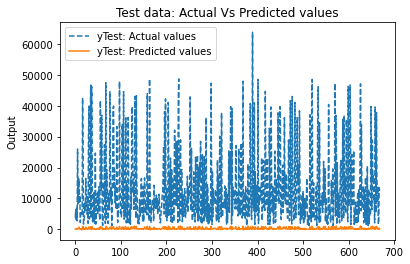

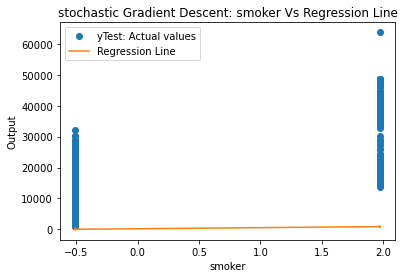

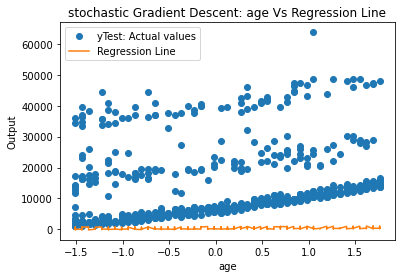

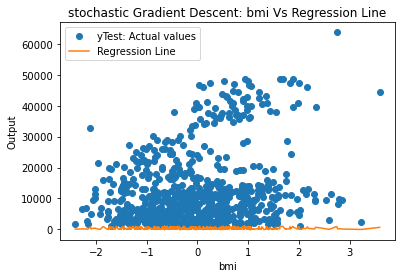

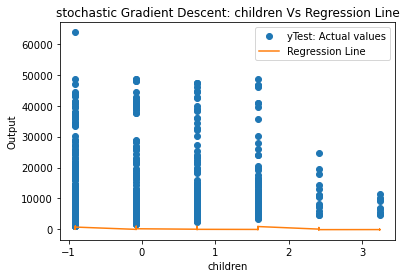

0    2.944753e+08
dtype: float64


In [589]:
#Dropping the minimum weight attribute and performing L1 regularization for stochastic gradient descent
l1XTrain = XTrain.drop(weights.idxmin()[0], axis=1)
l1XTest = XTest.drop(weights.idxmin()[0], axis=1)
weights = getWeights(alg_Type='stochastic',x_Train=l1XTrain,y_Train=YTrain,x_Test=l1XTest,y_Test=YTest,regularization='l2',learn_Rate=0.0001,threshold=1.027360e+06)

#age

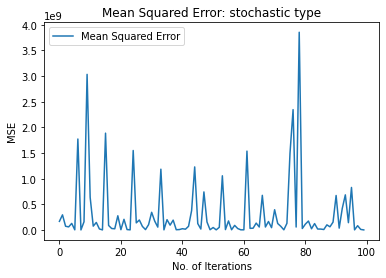

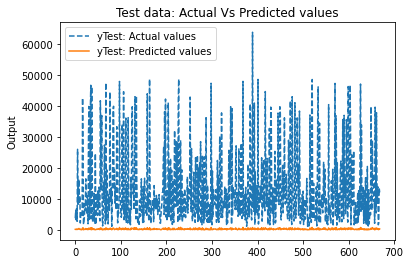

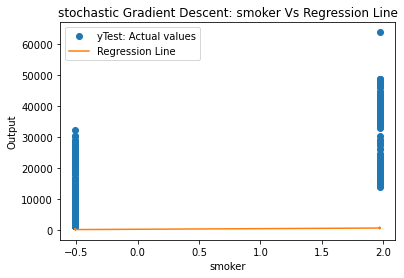

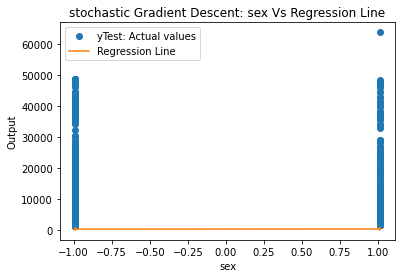

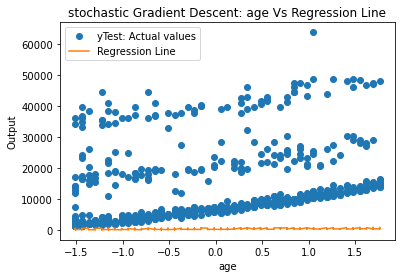

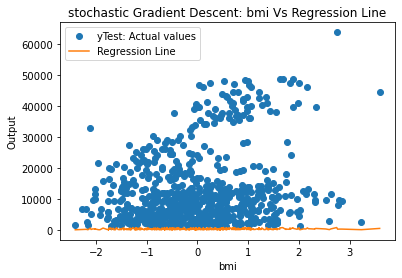

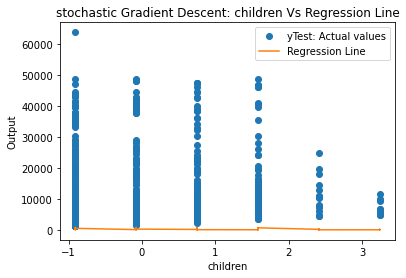

0    2.971377e+08
dtype: float64


In [590]:
#Stochastic Gradient Descent with L2 regularization
weights = getWeights(alg_Type='stochastic',x_Train=XTrain,y_Train=YTrain,x_Test=XTest,y_Test=YTest,regularization='l2',learn_Rate=0.0001,threshold=1.027360e+06)

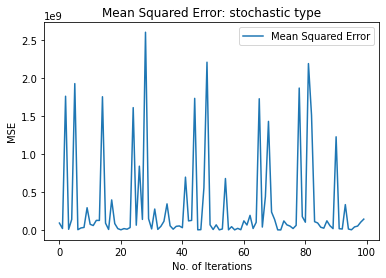

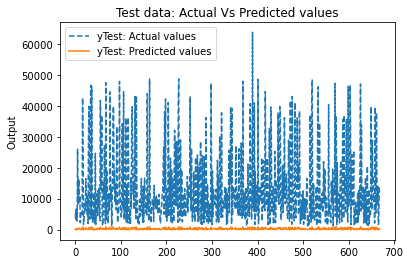

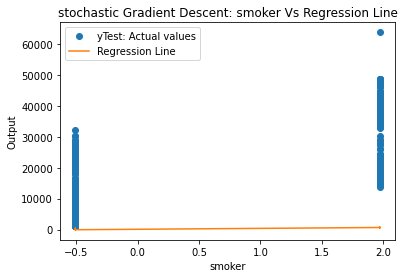

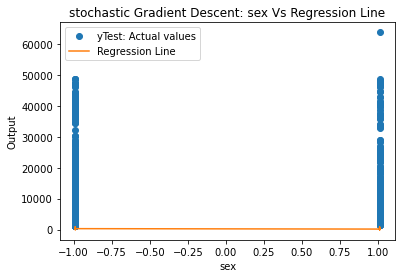

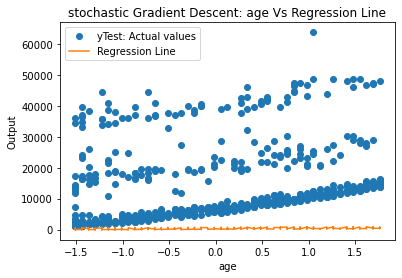

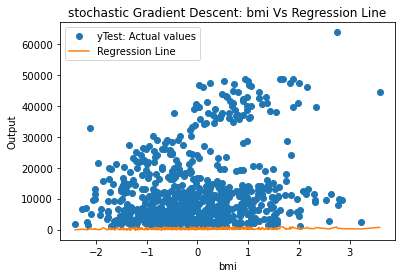

0    2.961237e+08
dtype: float64


In [591]:
#Dropping the minimum weight attribute and performing L2 regularization for stochastic gradient descent
l2XTrain = XTrain.drop(weights.idxmin()[0], axis=1)
l2XTest = XTest.drop(weights.idxmin()[0], axis=1)
weights = getWeights(alg_Type='stochastic',x_Train=l2XTrain,y_Train=YTrain,x_Test=l2XTest,y_Test=YTest,regularization='l2',learn_Rate=0.0001,threshold=1.027360e+06)
#sex

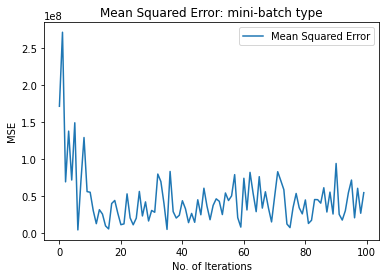

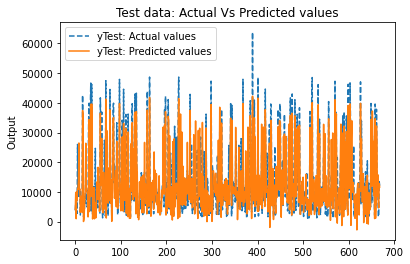

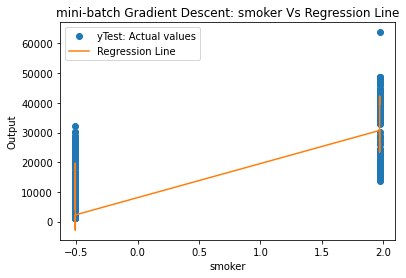

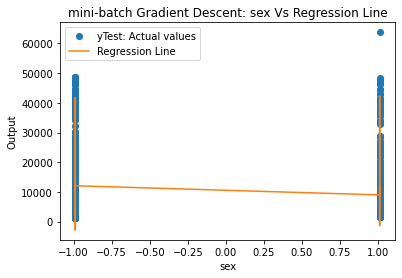

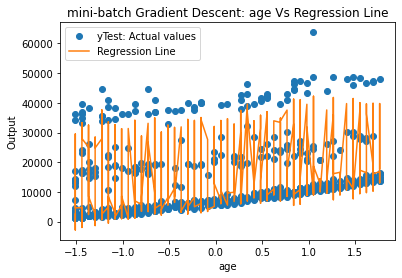

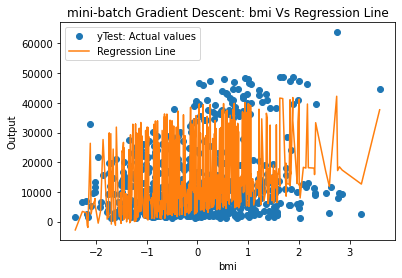

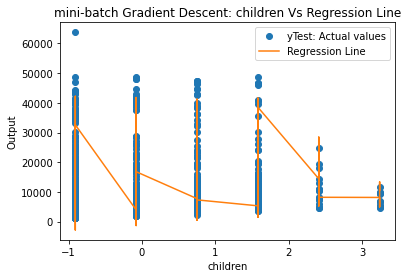

0    3.483302e+07
dtype: float64


In [592]:
#Mini-Batch Gradient Descent without regularization
weights = getWeights(alg_Type='mini-batch',x_Train=XTrain,y_Train=YTrain,x_Test=XTest,y_Test=YTest,learn_Rate=0.09,threshold=5.777738e+06)    

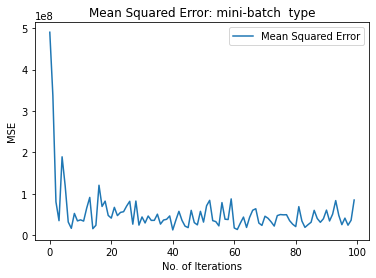

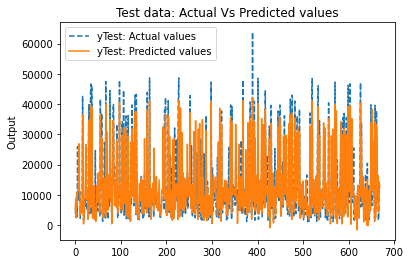

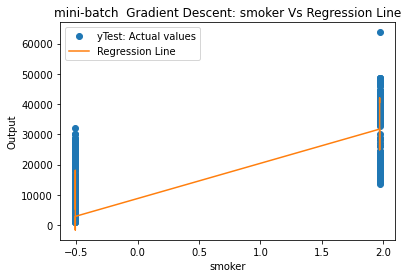

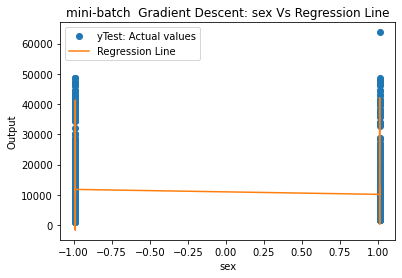

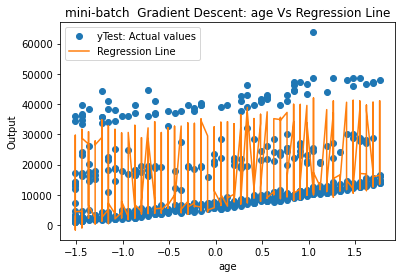

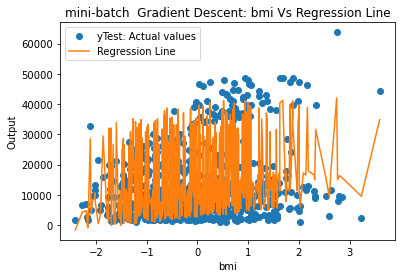

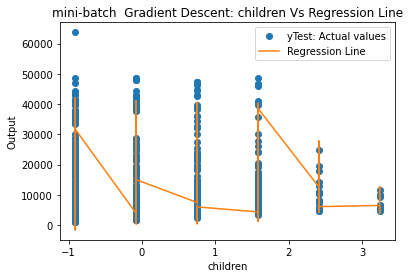

0    3.482503e+07
dtype: float64


In [593]:
#Mini-Batch Gradient Descent with L1 regularization
weights = getWeights(alg_Type='mini-batch ',x_Train=XTrain,y_Train=YTrain,x_Test=XTest,y_Test=YTest,regularization='l1',learn_Rate=0.09,threshold=5.777738e+06)

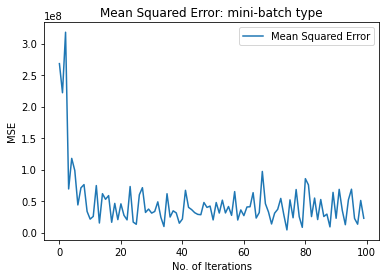

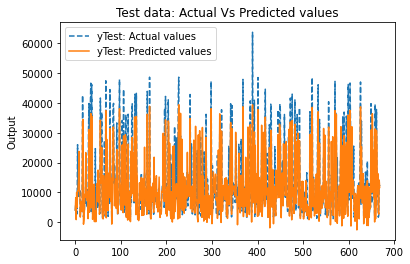

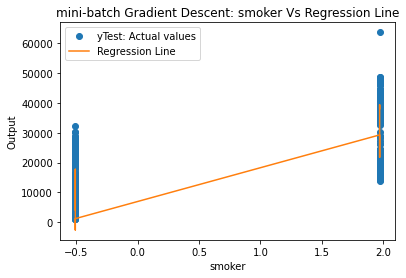

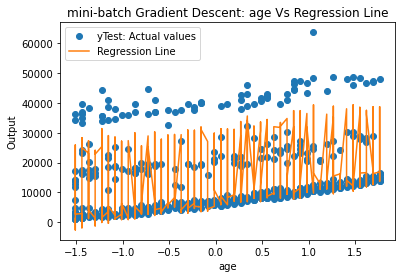

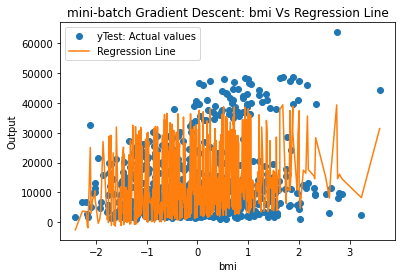

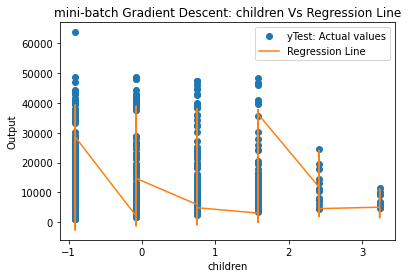

0    3.586344e+07
dtype: float64


In [594]:
#Dropping the minimum weight attribute and performing L1 regularization for mini-batch gradient descent
l1XTrain = XTrain.drop(weights.idxmin()[0], axis=1)
l1XTest = XTest.drop(weights.idxmin()[0], axis=1)

weights = getWeights(alg_Type='mini-batch',x_Train=l1XTrain,y_Train=YTrain,x_Test=l1XTest,y_Test=YTest,regularization='l1',learn_Rate=0.09,threshold=5.777738e+06)
#sex

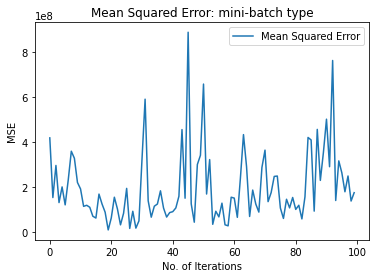

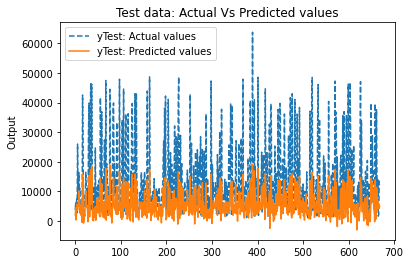

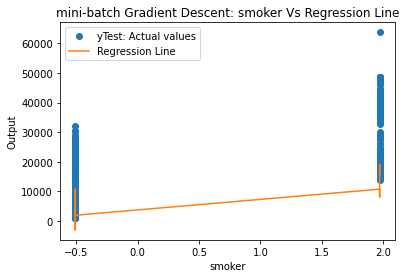

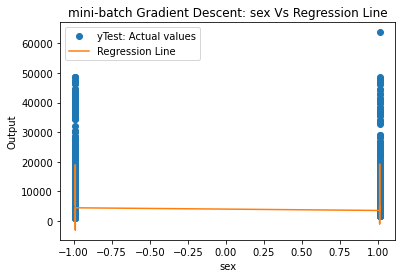

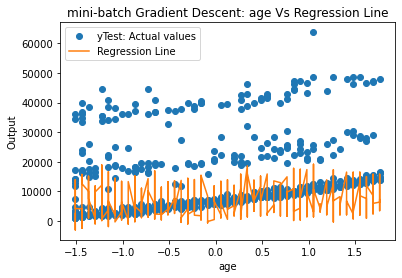

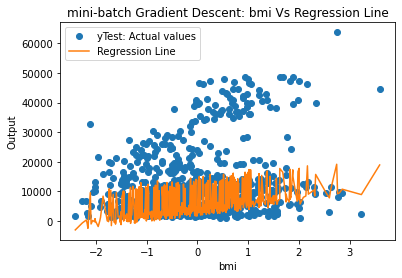

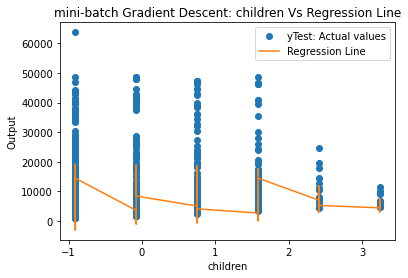

0    1.282517e+08
dtype: float64


In [595]:
#Mini-Batch Gradient Descent with L2 regularization
weights = getWeights(alg_Type='mini-batch',x_Train=XTrain,y_Train=YTrain,x_Test=XTest,y_Test=YTest,regularization='l2',learn_Rate=0.09,threshold=5.777738e+06)


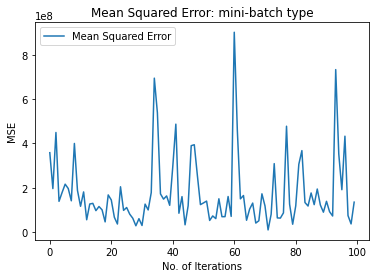

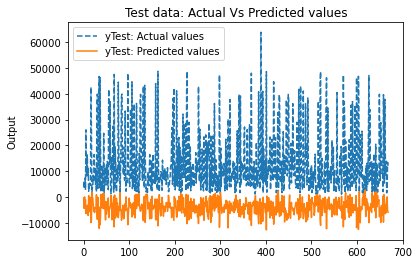

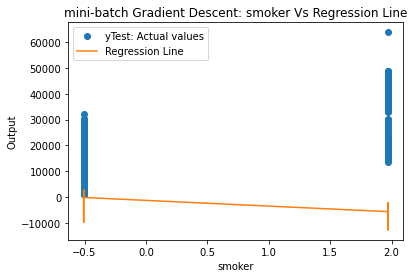

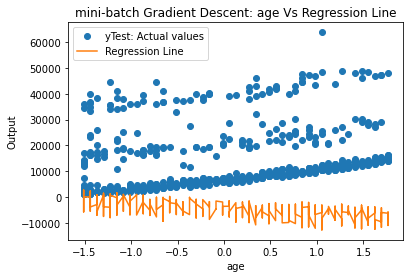

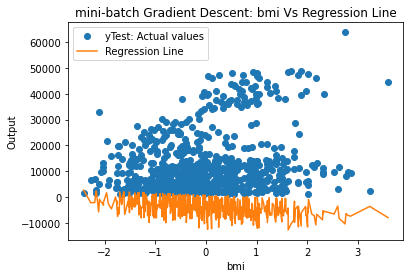

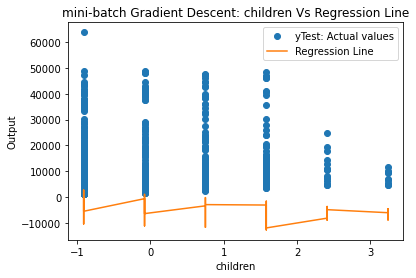

0    4.844315e+08
dtype: float64


In [596]:
#Dropping the minimum weight attribute and performing L2 regularization for mini-batch gradient descent
l2XTrain = XTrain.drop(weights.idxmin()[0], axis=1)
l2XTest = XTest.drop(weights.idxmin()[0], axis=1)
weights = getWeights(alg_Type='mini-batch',x_Train=l2XTrain,y_Train=YTrain,x_Test=l2XTest,y_Test=YTest,regularization='l2',learn_Rate=0.09,threshold=5.777738e+06)
#sex 